# Nx versus T and OA

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from IPython import get_ipython

# noinspection PyBroadException
try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from pathlib import Path

from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing, ds2df_echam
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log

from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import scienceplots
import scienceplots
plt.style.use([
    'default',
    # 'science',
    'acp',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])

In [5]:

import numpy as np

label_dic =dict(
    T_C=r'T  [$^\circ$C]',
    OA =r'OA [$\mu g m^{-3}$]',
)

In [6]:
select_station = 'SMR'

In [7]:
plot_path = Path(f'Plots/{select_station}')

In [8]:
def make_fn_scat(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_all_years_echam_noresm_{case}_{_x}_{_y}-{select_station}_ukesm.png'
    return plot_path /f

In [9]:
plot_path.mkdir(exist_ok=True, parents=True)

In [10]:
from bs_fdbck.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'

In [11]:
fn_obs_comb_data_full_time =postproc_data_obs /'SMEAR_data_comb_hourly.csv'

In [12]:
plot_path = Path(f'Plots/{select_station}')

In [13]:
def make_fn_eval(case,_type):
    #_x = v_x.split('(')[0]
    #_y = v_y.split('(')[0]
    f = f'evalOA_echam_{case}_{_type}_{select_station}.png'
    return plot_path /f

## Read in model data. 

In [14]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

In [15]:
from bs_fdbck.preprocess.launch_monthly_station_collocation import launch_monthly_station_output
from bs_fdbck.util.Nd.sizedist_class_v2.SizedistributionBins import SizedistributionStationBins
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.data_info.variable_info import list_sized_vars_nonsec, list_sized_vars_noresm
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
import numpy as np

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge

### Constants:

In [19]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15

In [20]:
import pandas as pd

## Read in model data

In [21]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv
UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_UKESM_AEROCOMTRAJ.csv


## Read in observations

In [22]:
df_obs = pd.read_csv(fn_obs_comb_data_full_time,index_col=0)

In [23]:
df_obs = df_obs.rename({'Org_STP':'OA', 'HYY_META.T168':'T_C'}, axis=1)

In [24]:
df_obs

,Year,Month,Day,Hour,Minute,Second,HYY_META.WDU672,HYY_META.WSU168,HYY_META.WSU672,HYY_META.T672,...,N150,N200,N250,N300,density,OA,SO4_STP,NO3_STP,NH4_STP,Chl_STP
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,2012.0,1.0,1.0,0.0,29.5,0.0,NaN,0.768877,NaN,-6.228155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,2012.0,1.0,1.0,1.0,29.5,0.0,NaN,0.487818,NaN,-5.951797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,2012.0,1.0,1.0,2.0,29.5,0.0,NaN,0.553307,NaN,-5.993273,...,137.173123,87.040280,52.205053,29.899803,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,2012.0,1.0,1.0,3.0,29.5,0.0,NaN,0.523611,NaN,-5.995248,...,152.428974,96.878629,59.321288,33.998613,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,2012.0,1.0,1.0,4.0,29.5,0.0,NaN,0.540031,NaN,-5.883390,...,189.614898,117.824268,70.343558,39.921649,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
dic_df_pre['Observations']=dict()
dic_df_pre['Observations']['Observations'] = df_obs
dic_df_pre['Observations']['Observations'].index = pd.to_datetime(dic_df_pre['Observations']['Observations'].index)

In [26]:
mod2cases['Observations']= ['Observations']

In [27]:
dic_mod_ca = dic_df_pre.copy()

### Fit funcs

In [28]:
from bs_fdbck.util.BSOA_datamanip.fits import *
from bs_fdbck.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [29]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

### Some definitions:

In [30]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

### Save result in dictionary

In [31]:
dic_df_mod_case = dic_mod_ca.copy()

In [32]:
from bs_fdbck.util.BSOA_datamanip import calculate_daily_median_summer,calculate_summer_median

NorESM
15456


<AxesSubplot:xlabel='time'>

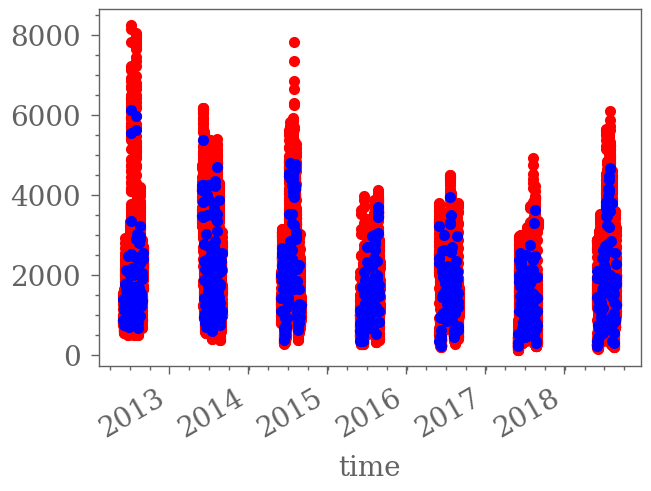

In [33]:

season = 'JJA'
mo ='NorESM'
df_s1 =  dic_df_mod_case['NorESM'][mod2cases['NorESM'][0]]#['N50'].plot()
print(mo)
mask_months = select_months(df_s1, season=season)
df_s1 = df_s1[mask_months].copy()
print(len(df_s1.dropna()))
df_s1['N50_STP'].plot(marker='.', linewidth=0, c='r')
df_s1.resample('D').median()['N50_STP'].plot(marker='.', linewidth=0, c='b')

EC-Earth
4905


<AxesSubplot:xlabel='time'>

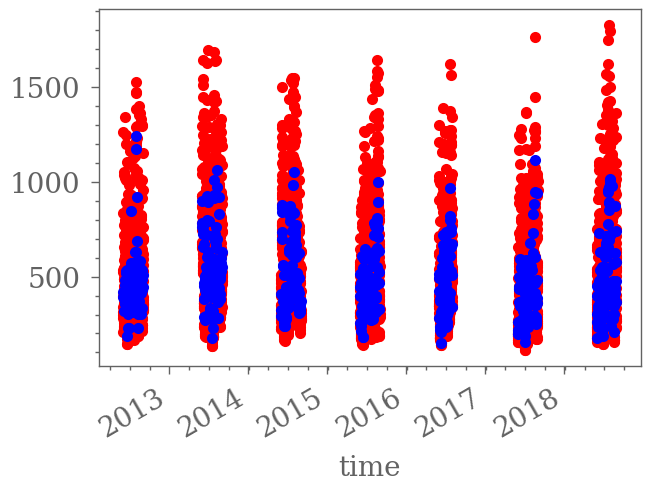

In [34]:

season = 'JJA'
mo ='EC-Earth'
df_s1 =  dic_df_mod_case['EC-Earth'][mod2cases['EC-Earth'][0]]#['N50'].plot()
print(mo)
mask_months = select_months(df_s1, season=season)
df_s1 = df_s1[mask_months].copy()
print(len(df_s1.dropna()))
df_s1['N50_STP'].plot(marker='.', linewidth=0, c='r')
df_s1.resample('D').median()['N50_STP'].plot(marker='.', linewidth=0, c='b')

In [35]:
df_s1.to_xarray()

<xarray.Dataset>
Dimensions:                        (time: 15456)
Coordinates:
  * time                           (time) datetime64[ns] 2012-06-01 ... 2018-...
Data variables: (12/89)
    station                        (time) object 'SMR' 'SMR' ... 'SMR' 'SMR'
    time_orig                      (time) object '2012-05-31 22:30:00' ... '2...
    lev                            (time) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    CCN0.20                        (time) float64 67.36 68.15 ... 223.9 219.4
    CCN1.00                        (time) float64 95.74 97.16 ... 295.4 290.5
    M_BCACS                        (time) float64 3.01e-11 ... 1.122e-10
    ...                             ...
    ambient2stp_correction_factor  (time) float64 nan nan 1.028 ... nan 1.068
    OA_STP                         (time) float64 nan nan 0.5868 ... nan 2.403
    N100_STP                       (time) float64 nan nan 102.7 ... nan 326.5
    N200_STP                       (time) float64 nan nan 41.76 ... nan 130.5
    N50_STP                        (time) float64 nan nan 209.8 ... nan 596.0
    month                          (time) int64 6 6 6 6 6 6 6 ... 8 8 8 8 8 8 8

# Merge with observations:

In [36]:
dic_df_pre = dict()#dic_df_mod_case.copy()#deep=True)
for mod in dic_df_mod_case.keys():
    dic_df_pre[mod] = dic_df_mod_case[mod].copy()

## Rename STP values

In [37]:
for mod in models:
    for ca in mod2cases[mod]:
        _df = dic_df_pre[mod][ca]
        for v in ['OA','N50','N100','N200']:
            if f'{v}_STP' in _df.columns:
                if v in _df.columns:
                    _df = _df.rename({v:f'{v}_orig'}, axis=1)
                _df = _df.rename({f'{v}_STP':v}, axis=1)
        dic_df_pre[mod][ca] = _df

In [38]:
vars_obs = ['OA', 'N100','N50','N200','T_C']

In [39]:
df_obs = df_obs[vars_obs]

In [40]:
df_obs['some_obs_missing'] = df_obs[vars_obs].isnull().any(axis=1)

/tmp/ipykernel_94188/3053598488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['some_obs_missing'] = df_obs[vars_obs].isnull().any(axis=1)


In [41]:
df_for_merge = df_obs[['OA','N100', 'some_obs_missing']].rename({'OA':'obs_OA','N100':'obs_N100',},axis=1)

In [42]:
for mod in dic_df_mod_case.keys():
    print(mod)
    for ca in dic_df_mod_case[mod].keys():
        dic_df_mod_case[mod][ca] = pd.merge(dic_df_pre[mod][ca], df_for_merge ,right_on='time', left_on='time', how='outer')
        dic_df_mod_case[mod][ca]['year'] = dic_df_mod_case[mod][ca].index.year

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


## Add observations to dictionary

In [43]:
dic_df_mod_case['Observations'] = dict()
dic_df_mod_case['Observations']['Observations'] = df_obs

In [44]:
dic_df_mod_case['Observations'].keys()

dict_keys(['Observations'])

In [45]:
dic_mod2case = mod2cases

In [46]:
def add_log(df, varl=None):
    if varl is None:
        varl = ['OA','N100', 'Org','N100 (cm^-3)','N50','N150','N200']
    var_exist = df.columns
    
    varl_f = set(varl).intersection(var_exist)
    print(varl_f)
    for v in varl_f:
        df[f'log10({v})'] = np.log10(df[v])
    return df


for mod in dic_df_mod_case.keys():
    for c in dic_df_mod_case[mod].keys():
    
        dic_df_mod_case[mod][c] = add_log(dic_df_mod_case[mod][c].copy())
        #dic_dfsm_mod_case[mod][c] = add_log(dic_dfsm_mod_case[mod][c])
        
dic_df_mod_case['Observations']['Observations'] = add_log(dic_df_mod_case['Observations']['Observations'])
df_ons = dic_df_mod_case['Observations']['Observations']

{'N100', 'OA', 'N50', 'N200'}
{'N150', 'N50', 'N200', 'N100', 'OA'}
{'N150', 'N50', 'N200', 'N100', 'OA'}
{'N150', 'N50', 'N200', 'N100', 'OA'}
{'N100', 'OA', 'N50', 'N200'}
{'N100', 'OA', 'N50', 'N200'}


/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
mod='NorESM'

In [48]:
ca = mod2cases[mod][0]

## Compute daily medians:

In [49]:
path_save_daily_medians = Path(f'Temp_data/{select_station}_daily_medians')
path_save_daily_medians.parent.mkdir(exist_ok=True)

In [50]:
dic_df_med = dict()
for mo in dic_df_mod_case.keys():
    for ca in dic_df_mod_case[mo].keys():
        if len(dic_df_mod_case[mo].keys())>1:
            use_name = f'{mo}_{ca}'
        else:
            use_name = mo
            
        _df = dic_df_mod_case[mo][ca]
        
        _df = _df[_df['some_obs_missing']==False]
        dic_df_med[use_name] = _df.resample('D').median()
        
        fp = path_save_daily_medians.parent / f'{path_save_daily_medians.name}_{use_name}.csv'
        dic_df_med[use_name].to_csv(fp)

In [51]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model
import seaborn as sns
from matplotlib import pyplot as plt, gridspec as gridspec
from bs_fdbck.util.plot.BSOA_plots import make_cool_grid2, make_cool_grid3
import scipy

### Fit funcs

In [52]:
from bs_fdbck.util.BSOA_datamanip.fits import *
from bs_fdbck.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [53]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

In [54]:
from bs_fdbck.util.BSOA_datamanip.fits import *

In [55]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model, make_cool_grid5

In [56]:
models

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM']

In [57]:
models_and_obs =  models + ['Observations'] 
models_and_obs

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations']

## Make plot

In [58]:
def make_plot(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.2,
             source_list = models_and_obs, fig=None, ax=None, daxs=None, axs_extra=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
             ):
    if fig is None: 
        fig, ax, daxs, axs_extra = make_cool_grid3(ncols_extra=2, nrows_extra=3,)# w_ratio_sideplot=.5)

    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()


        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt*.7, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                   )
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax_ex,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                    
                   )
        ax_ex.set_title(mo, y=.95)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    xlim_dist = list(daxs['y'].get_xlim())
    for mo in models_and_obs:

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        sns.histplot(#x=v_x,
                    x= df_s[v_x], 
            edgecolor=cdic_model[mo],
            #log_scale=(xscale=='log'),
            color=cdic_model[mo], 
            element="step",
            label=mo,
            linewidth=1,
            #log_scale=(xscale=='log',False,),

            alpha=.1,
            bins=xbins,
            ax = daxs['x'],
                    
                   )
        print(daxs['x'].get_ylim())
        _fi, ax_test = plt.subplots();
        ax_test = sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = ax_test,
            #ax = daxs['y'],
            linewidth=2,
            
            #edgecolor=None,
            #log_scale=(False,yscale=='log'),
            alpha=.1,
            bins=ybins,
        );
        
        sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = daxs['y'],
            linewidth=1,
            
            #edgecolor=None,
            #log_scale=(xscale=='log',yscale=='log'),
            #log_scale=(False,yscale=='log'),
            
            alpha=.1,
            bins=ybins,
            )
        xlim_dist_n = list(ax_test.get_xlim())
        _fi.clf()
        #if xlim_dist_n[1]>xlim_dist_n[1]:
        xlim_dist[1] = max(xlim_dist_n[1],xlim_dist[1])
        #daxs['y'].set_xlim([0,xlim_dist[1]])
        
        #plt.show()

    ax.set_ylim(ylims)
    ax.set_xlim(xlims)


    for ax_e in axs_extra:
        ax_e.set_xlabel('')
        ax_e.set_ylabel('')
        ax_e.set_ylim(ax.get_ylim())
        ax_e.set_xlim(ax.get_xlim())
        ax_e.axes.xaxis.set_ticklabels([])
        ax_e.axes.yaxis.set_ticklabels([])

        sns.despine(ax = ax_e)

    return

#### WET_mid

## T to OA, exp

### JA

In [59]:
models_and_obs

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations']

<AxesSubplot:xlabel='time'>

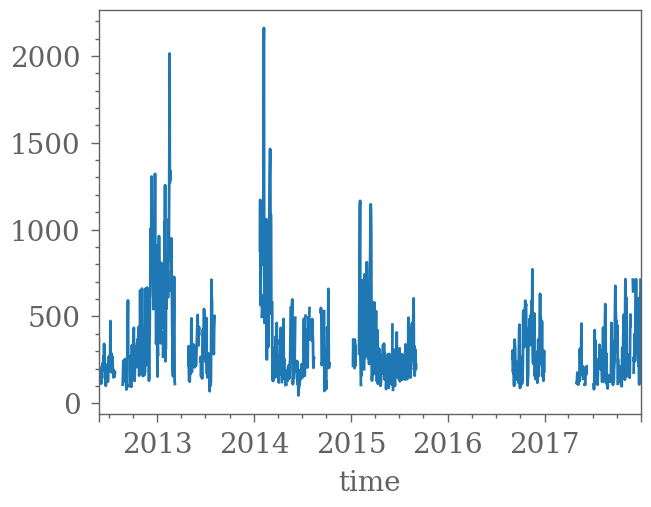

In [60]:
df_s =  dic_df_med['EC-Earth']
df_s['N100'].plot()

In [61]:
models_and_obs

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations']

(0.0, 47.25)
(0.0, 47.25)
(0.0, 52.5)
(0.0, 52.5)
(0.0, 52.5)
ECHAM-SALSA
ECHAM-SALSA
[0.01, 0.12]
Beta: [0.01456143 0.23905216]
Beta Std Error: [0.00368697 0.01287855]
Beta Covariance: [[ 7.23455039e-05 -2.50397114e-04]
 [-2.50397114e-04  8.82684706e-04]]
Residual Variance: 0.18790055293655214
Inverse Condition #: 0.031341142178484126
Reason(s) for Halting:
  Sum of squares convergence
[0.01456143 0.23905216]
reason for haltng
NorESM
NorESM
[0.01, 0.12]
Beta: [0.0733049  0.18858169]
Beta Std Error: [0.01281935 0.00940513]
Beta Covariance: [[ 0.00099561 -0.00071942]
 [-0.00071942  0.00053591]]
Residual Variance: 0.16505962826031081
Inverse Condition #: 0.010083100644064367
Reason(s) for Halting:
  Sum of squares convergence
[0.0733049  0.18858169]
reason for haltng
EC-Earth
EC-Earth
[0.01, 0.12]
Beta: [0.05282176 0.2219964 ]
Beta Std Error: [0.01282448 0.01397708]
Beta Covariance: [[ 0.00060006 -0.00064814]
 [-0.00064814  0.00071276]]
Residual Variance: 0.27408644449958314
Inverse Cond

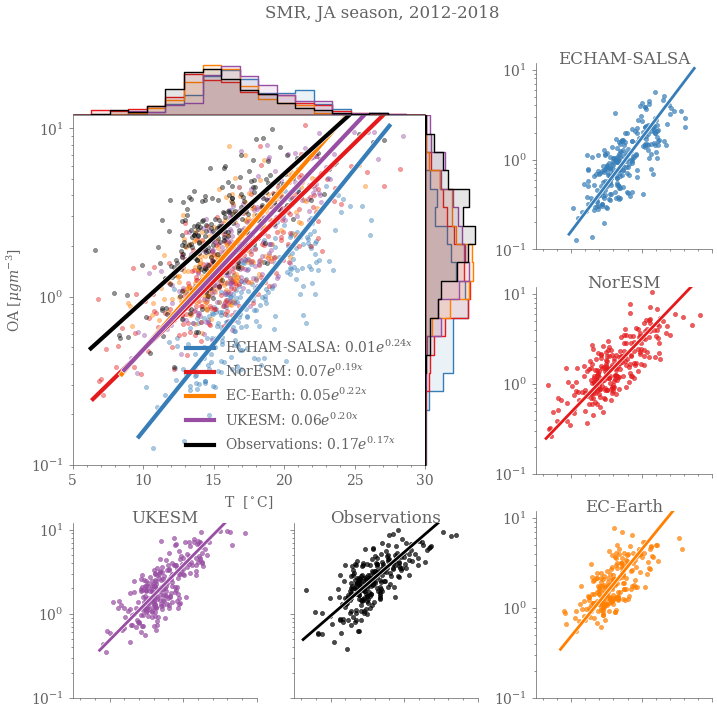

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [62]:
fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,12]


season='JA'
v_x = 'T_C'
v_y = 'OA'


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')


    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



plt.show()

### Residuals

ECHAM-SALSA
[0.01, 0.12]
Beta: [0.01456143 0.23905216]
Beta Std Error: [0.00368697 0.01287855]
Beta Covariance: [[ 7.23455039e-05 -2.50397114e-04]
 [-2.50397114e-04  8.82684706e-04]]
Residual Variance: 0.18790055293655214
Inverse Condition #: 0.031341142178484126
Reason(s) for Halting:
  Sum of squares convergence
[0.01456143 0.23905216]
reason for haltng
NorESM
[0.01, 0.12]
Beta: [0.0733049  0.18858169]
Beta Std Error: [0.01281935 0.00940513]
Beta Covariance: [[ 0.00099561 -0.00071942]
 [-0.00071942  0.00053591]]
Residual Variance: 0.16505962826031081
Inverse Condition #: 0.010083100644064367
Reason(s) for Halting:
  Sum of squares convergence
[0.0733049  0.18858169]
reason for haltng
EC-Earth
[0.01, 0.12]
Beta: [0.05282176 0.2219964 ]
Beta Std Error: [0.01282448 0.01397708]
Beta Covariance: [[ 0.00060006 -0.00064814]
 [-0.00064814  0.00071276]]
Residual Variance: 0.27408644449958314
Inverse Condition #: 0.011240997205949422
Reason(s) for Halting:
  Sum of squares convergence
[0.05282

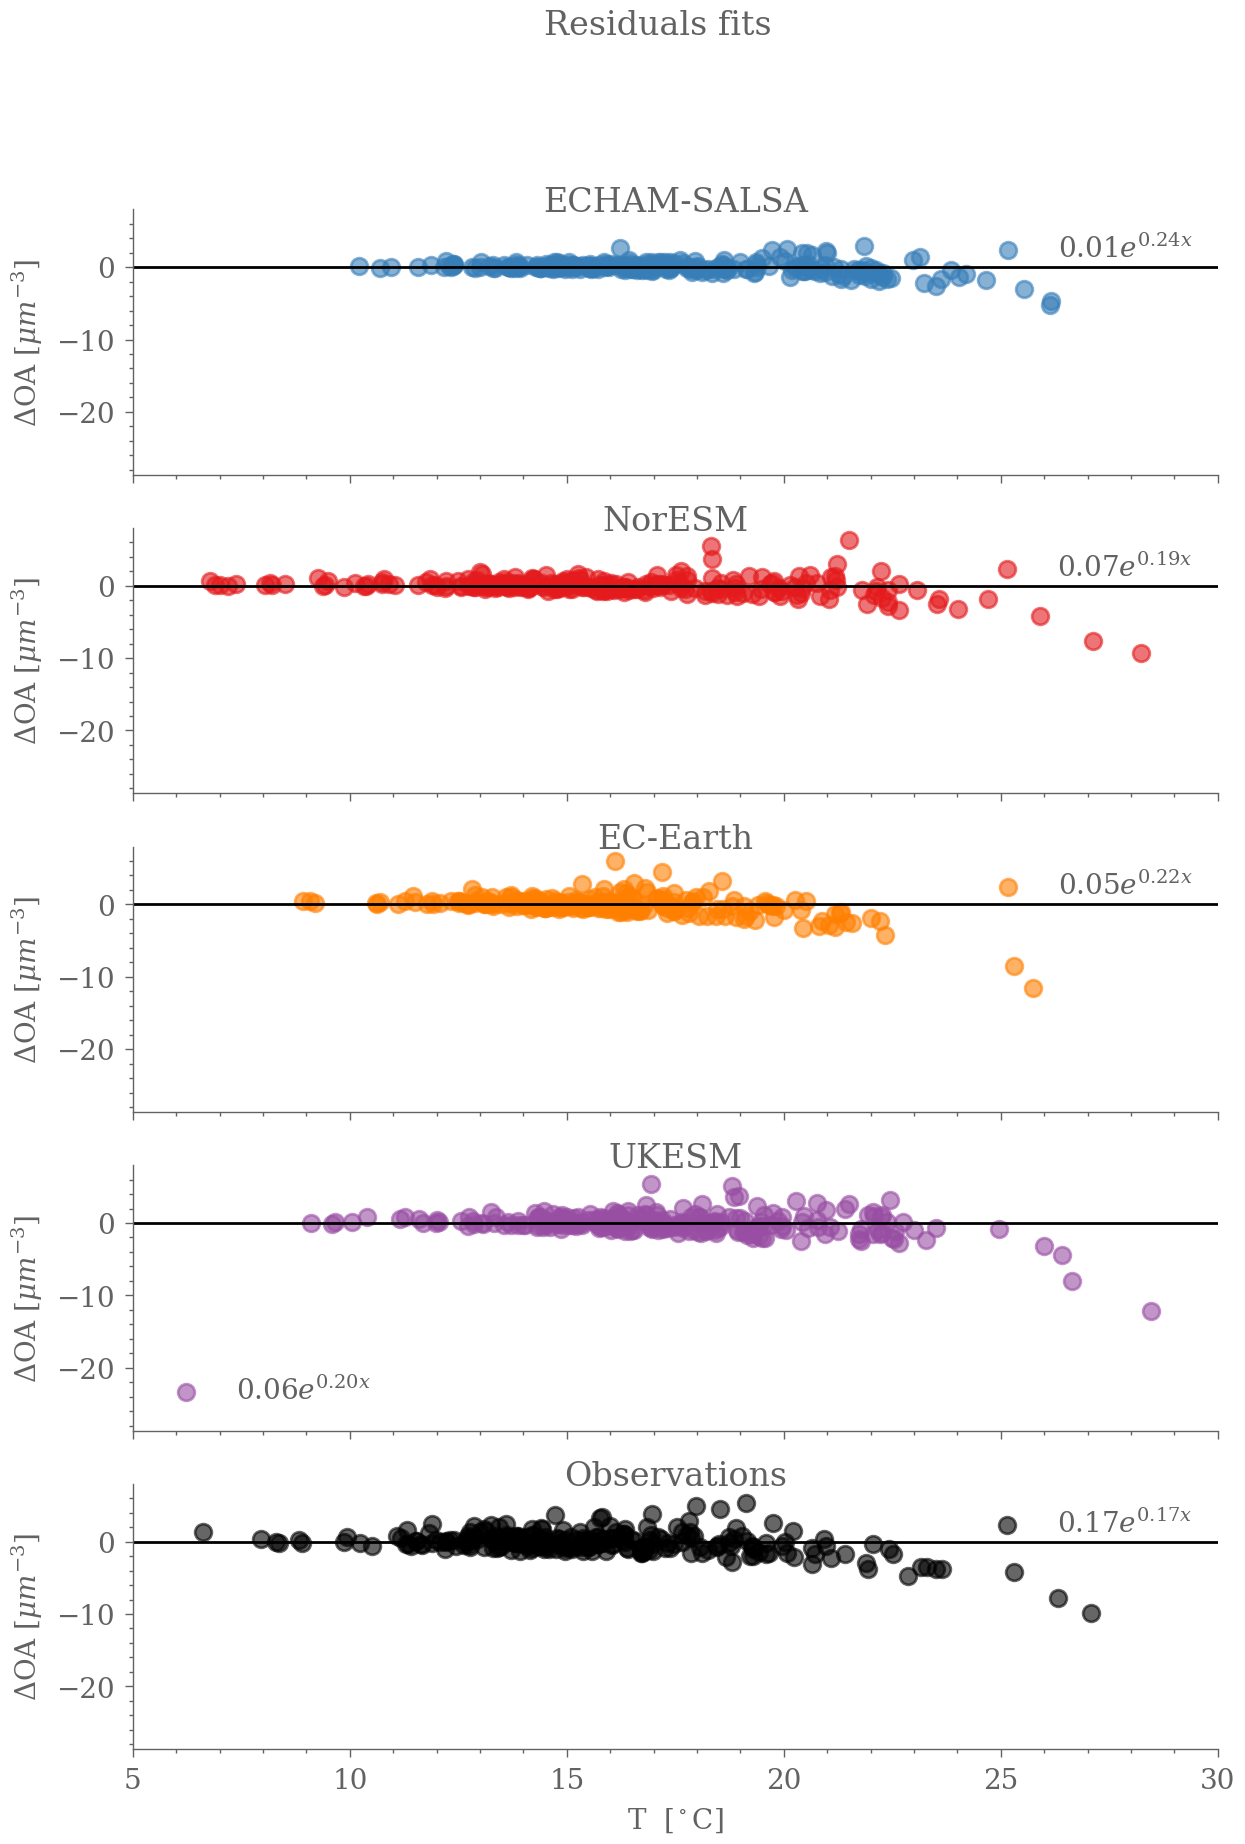

In [63]:

## Settings
alpha_scatt = 0.5

figsize=[7,10]
xlab = r'T  [$^\circ$C]'
ylab = r'$\Delta$OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [5,30]

#ylims = [1,700]

# OBS: 
v_y = 'OA'
v_x = 'T_C'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6


for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)
    ax.set_title(mo, y=.93)
    ax.set_xlim(xlims)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
fig.suptitle(r'Residuals fits')

sns.despine(fig)    
    
fn = make_fn_scat(f'residual_ln_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

# Nx new version

In [64]:
def make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.4,
             source_list = models_and_obs, fig=None, 
               axs=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
             ):
    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax in zip(source_list, axs[:]):
        
        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                    
                   )
        ax.set_title(mo, y=.95)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    xlim_dist = list(daxs['y'].get_xlim())
    for mo,ax in zip(source_list, axs):

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        ax.set_ylim(ylims)
        ax.set_xlim(xlims)

        sns.despine(ax = ax)

    return

#### WET_mid

In [65]:
def plot_fit(func, popt, mo, xlims, yscale, xscale, ax):
    x = np.linspace(*xlims)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))
    
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{label}')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))

    #ax.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
    #
    #)

    #ax.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
    #          )    
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)



In [66]:
dic_df_med['EC-Earth']

,lev,CCN0.20,CCN1.00,M_BCACS,M_BCAII,M_BCAIS,M_BCCOS,M_DUACI,M_DUACS,M_DUCOI,...,N50,month,obs_OA,obs_N100,year,log10(N150),log10(N50),log10(N200),log10(N100),log10(OA)
time,,,,,,,,,,,,,,,,,,,,,
2012-05-24,1.0,119.009600,195.623230,5.375215e-11,1.835692e-11,3.808274e-12,6.296829e-15,2.376486e-11,3.201019e-10,2.594339e-11,...,296.880895,5,3.216138,804.539690,2012.0,2.014065,2.472553,1.859674,2.205234,0.094885
2012-05-25,1.0,176.983520,273.521330,9.313450e-11,1.167251e-10,3.127727e-12,4.983523e-15,1.298050e-11,2.874597e-10,3.033447e-11,...,851.040188,5,2.936349,814.568575,2012.0,2.240032,2.921267,2.062673,2.556224,0.353061
2012-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-28,1.0,110.621765,196.707190,5.273481e-11,2.042820e-11,4.006450e-12,6.006080e-15,4.528452e-13,1.317444e-10,4.983879e-12,...,295.909853,5,0.960024,256.294932,2012.0,1.960119,2.471159,1.776019,2.159370,-0.026426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1.0,217.450240,275.235000,1.172492e-10,1.626678e-10,2.925313e-12,9.850782e-16,3.466120e-12,1.317694e-11,8.255179e-13,...,964.577148,12,0.429355,128.957746,2017.0,2.281038,2.982404,2.055590,2.578895,0.147838
2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-29,1.0,509.545070,626.709000,2.910700e-10,1.727751e-10,6.397750e-12,1.014083e-15,2.339462e-13,2.062769e-11,6.113175e-13,...,1423.515322,12,1.986983,595.511553,2017.0,2.626195,3.153362,2.421366,2.851993,0.437847


In [67]:
df_s[[v_x,v_y]]

,T_C,OA
time,,
2012-07-01,17.326756,3.244187
2012-07-02,16.771493,1.810452
2012-07-03,17.385451,2.464159
2012-07-04,18.118302,2.242064
2012-07-05,19.286427,3.677695
...,...,...
2017-08-27,8.309417,0.594172
2017-08-28,7.942333,1.049948
2017-08-29,6.614500,1.901274


In [68]:
df_s[[v_x,v_y]].dropna()

,T_C,OA
time,,
2012-07-01,17.326756,3.244187
2012-07-02,16.771493,1.810452
2012-07-03,17.385451,2.464159
2012-07-04,18.118302,2.242064
2012-07-05,19.286427,3.677695
...,...,...
2017-08-25,8.829750,1.019756
2017-08-26,8.363333,0.567893
2017-08-27,8.309417,0.594172


In [69]:
_df = df_s[[v_x,v_y]].dropna()

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
UKESM
EC-Earth
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

[301.02217364 -40.083809  ]
Beta: [309.70506919 -56.8184244 ]
Beta Std Error: [ 4.74766876 11.49313222]
Beta Covariance: [[  797.38431001 -1536.80518327]
 [-1536.80518327  4672.8696804 ]]
Residual Variance: 0.028267873327671323
Inverse Condition #: 0.21584344675670597
Reason(s) for Halting:
  Sum of squares convergence
[309.70506919 -56.8184244 ]
reason for haltng
ECHAM-SALSA
Observations
[51.33455411 -2.93983924]
Beta: [ 54.27778527 -11.52808036]
Beta Std Error: [1.16494005 3.98628286]
Beta Covariance: [[ 24.82113316 -72.42712977]
 [-72.42712977 290.63685009]]
Residual Variance: 0.05467459151992985
Inverse Condition #: 0.00869247714809772
Reason(s) for Halting:
  Sum of squares convergence
[ 54.27778527 -11.52808036]
reason for haltng
UKESM
[128.15001343  77.98550023]
Beta: [131.23629902  69.71123139]
Beta Std Error: [1.84809253 6.15685817]
Beta Covariance: [[ 144.03221917 -386.14751216]
 [-386.14751216 1598.56583782]]
Residual Variance: 0.02371306930722258
Inverse Condition #: 0.1608

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/SMR/scat_all_years_echam_noresm_together_JA_OA_Nx-SMR_ukesm.png


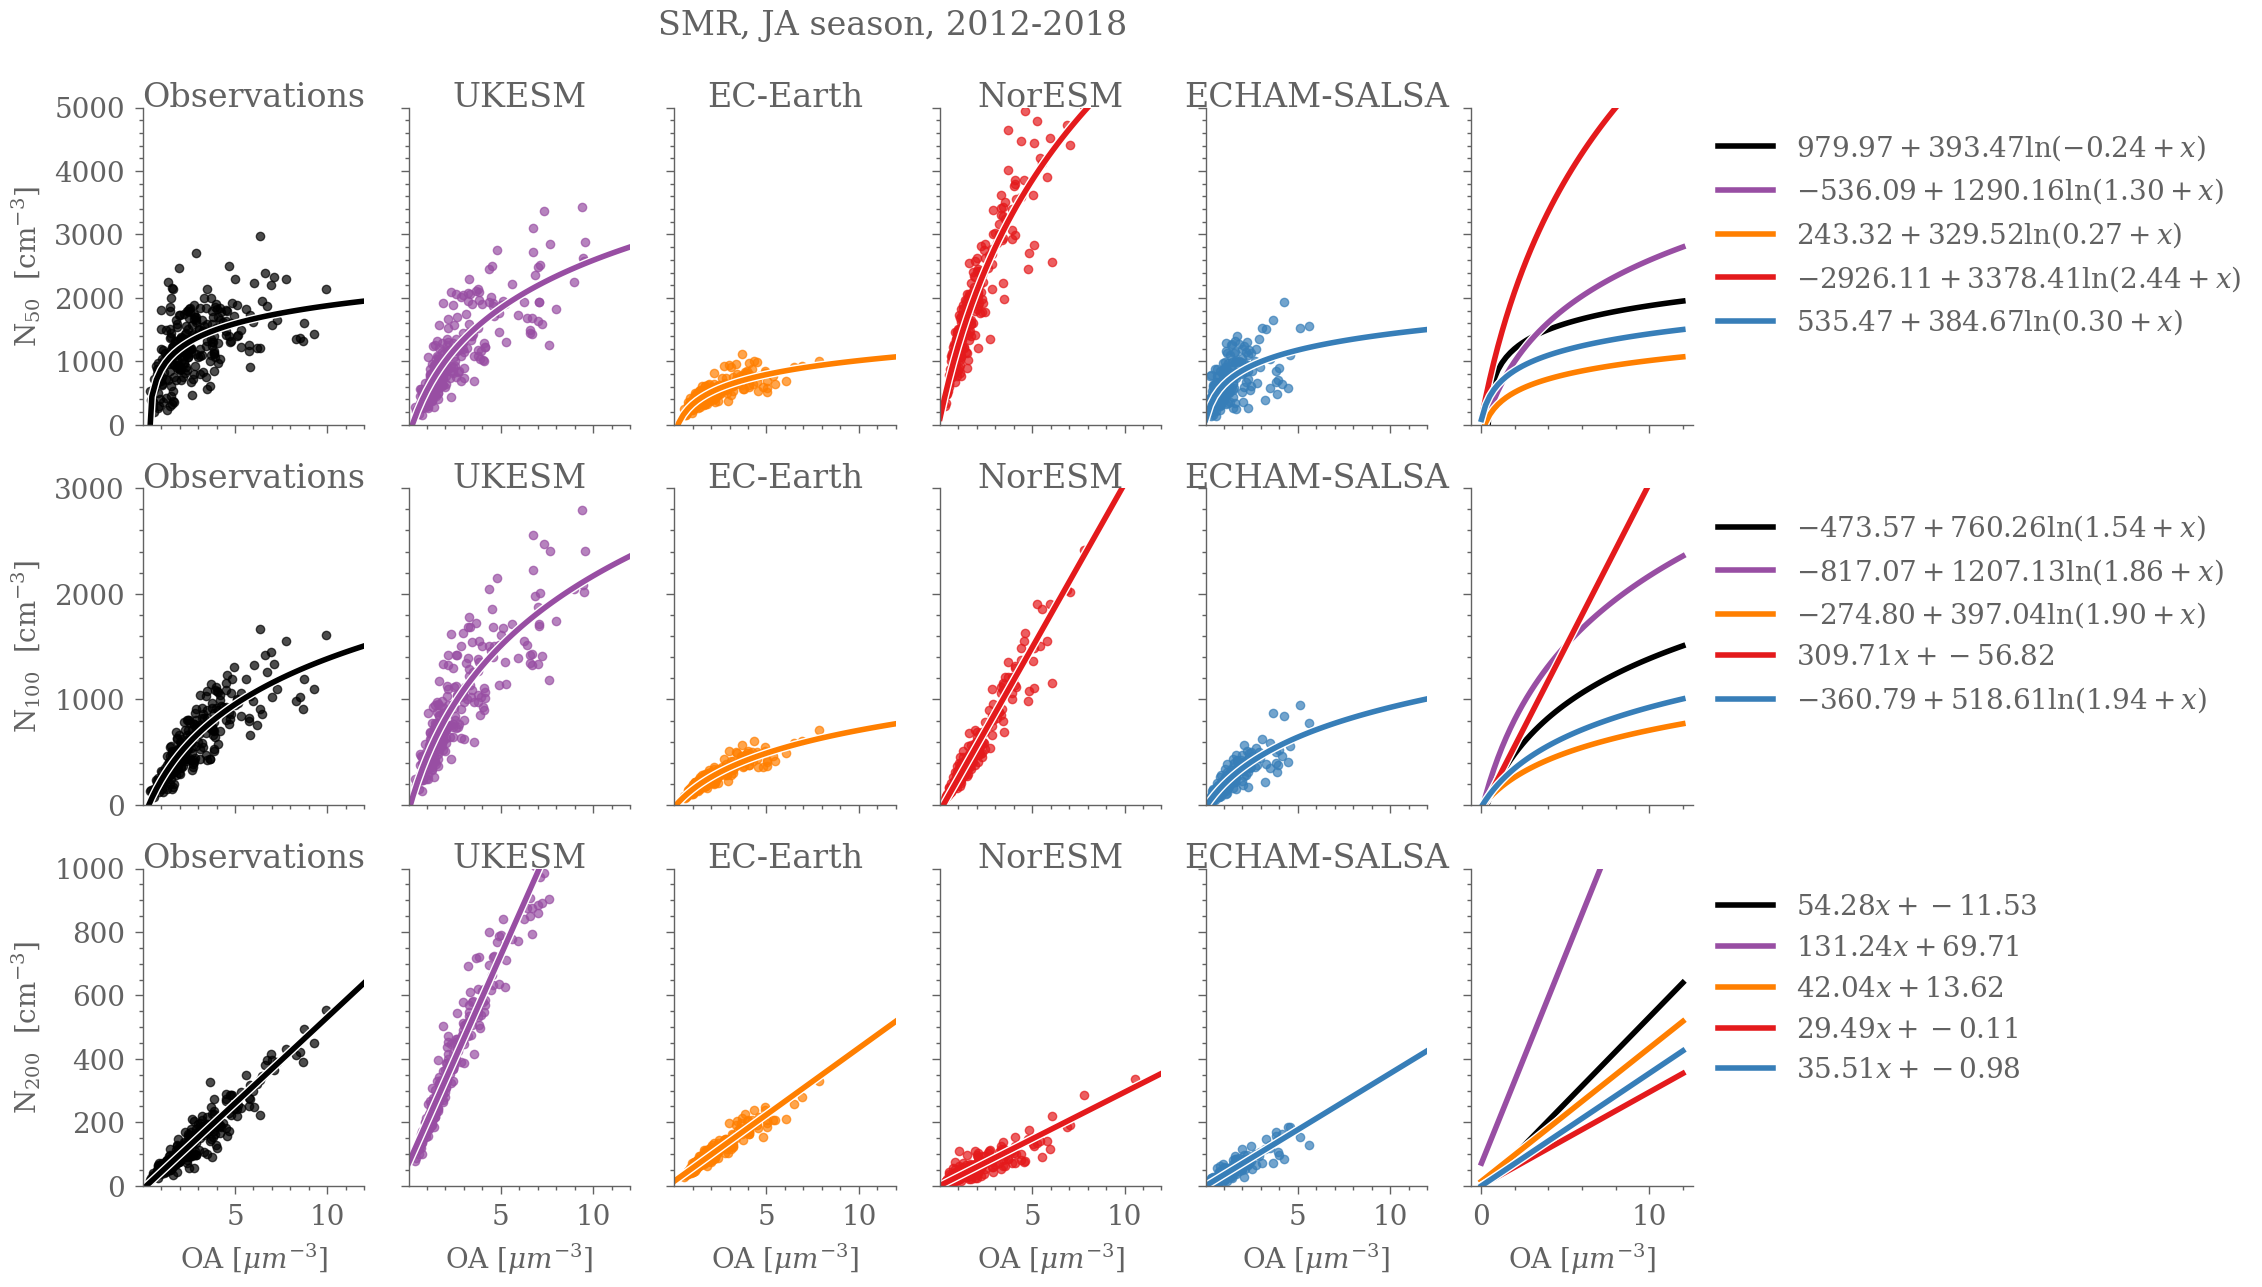

In [70]:
## Settings
alpha_scatt = 0.5
figsize=[10,7]

xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
source_list = models_and_obs[::-1]

xlims = [.01,12]

ylims = [0,5000]

# OBS: 
v_y = 'N50'
v_x = 'OA'
ylab = r'N$_{50}$  [cm$^{-3}$]'



xscale='linear'
yscale='linear'

fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')


## Settings
alpha_scatt = 0.6

legs =[]

# Make plot
axs_sub = axs_all[0,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )


for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    
    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)


xlims = [.01,12]

ylims = [0,3000]

# OBS: 
v_y = 'N100'
ylab = r'N$_{100}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[1,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list =source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )
for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    try:
        popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    except:
        #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
        popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        
    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

#leg = axs_sub[-1].legend(bbox_to_anchor=(1.1,1,), frameon=False)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)

    
    
xlims = [.01,12]

ylims = [0,1000]


# OBS: 
v_y = 'N200'
ylab = r'N$_{200}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[2,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )

for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)
legs.append(leg)

    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 



    
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
#ax.legend(frameon=False)
fig.savefig(fn, dpi=150, bbox_inches='tight')#)
fig.savefig(fn.with_suffix('.pdf'), dpi=150, bbox_inches='tight')#)
print(fn)

In [71]:
dic_df_med.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

Observations
[140.73478495 863.47696241]
Beta: [278.41583497 461.72879793]
Beta Std Error: [20.51606946 68.00228967]
Beta Covariance: [[  844.10137553 -2463.05634642]
 [-2463.05634642  9273.7067419 ]]
Residual Variance: 0.49864757736119925
Inverse Condition #: 0.1242726307142997
Reason(s) for Halting:
  Sum of squares convergence
[278.41583497 461.72879793]
reason for haltng
UKESM
[272.53913646 384.56804983]
Beta: [333.41601174 221.35838152]
Beta Std Error: [13.64390178 44.80510206]
Beta Covariance: [[ 1011.03791638 -2710.57217446]
 [-2710.57217446 10902.98000992]]
Residual Variance: 0.18412371374414185
Inverse Condition #: 0.1575498151266234
Reason(s) for Halting:
  Sum of squares convergence
[333.41601174 221.35838152]
reason for haltng
EC-Earth
[116.69052685 242.69370478]
Beta: [144.58710845 183.20004633]
Beta Std Error: [ 6.32789487 15.61675038]
Beta Covariance: [[ 205.66917549 -438.62048348]
 [-438.62048348 1252.6566065 ]]
Residual Variance: 0.19469253676544251
Inverse Condition #

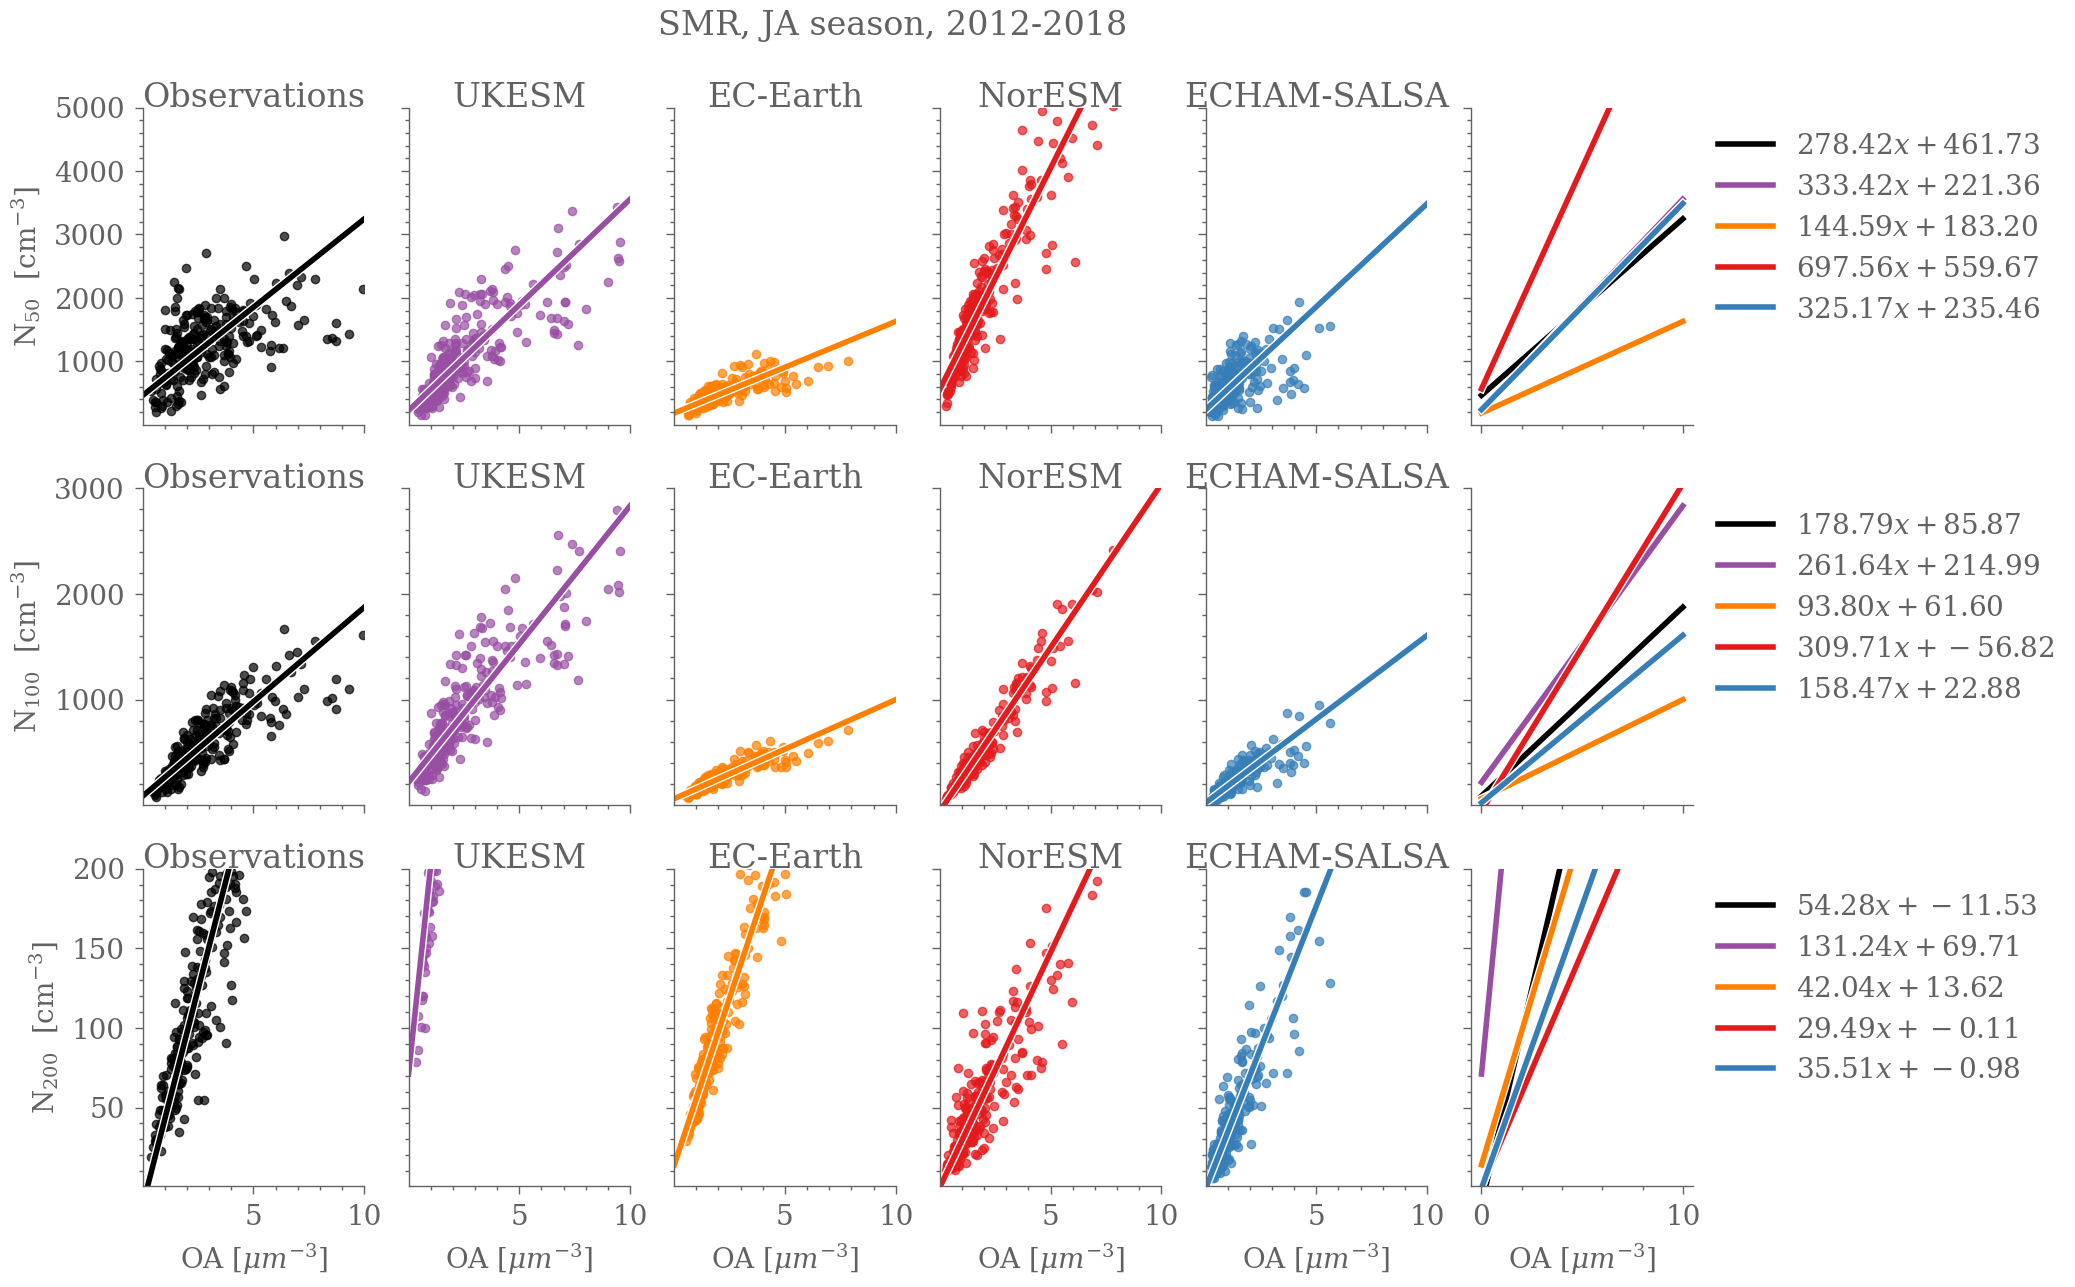

In [72]:
## Settings
alpha_scatt = 0.5
figsize=[10,7]

xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
source_list = models_and_obs[::-1]

xlims = [.01,10]

ylims = [1,5000]

# OBS: 
v_y = 'N50'
v_x = 'OA'
ylab = r'N$_{50}$  [cm$^{-3}$]'



xscale='linear'
yscale='linear'

fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')


## Settings
alpha_scatt = 0.6

legs =[]

# Make plot
axs_sub = axs_all[0,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )


for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)


xlims = [.01,10]

ylims = [1,3000]

# OBS: 
v_y = 'N100'
ylab = r'N$_{100}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[1,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list =source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )
for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

#leg = axs_sub[-1].legend(bbox_to_anchor=(1.1,1,), frameon=False)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)

    
    
xlims = [.01,10]

ylims = [1,200]





# OBS: 
v_y = 'N200'
ylab = r'N$_{200}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[2,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )

for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)
legs.append(leg)

    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 



    
fn = make_fn_scat(f'together_linear_{season}', v_x, 'Nx')
#ax.legend(frameon=False)
fig.savefig(fn, dpi=150, bbox_inches='tight')#)
fig.savefig(fn.with_suffix('.pdf'), dpi=150, bbox_inches='tight')#)
print(fn)

[Plots/SMR/scat_all_years_echam_noresm_together_JA_OA_Nx-SMR_ukesm.png](Plots/SMR/scat_all_years_echam_noresm_together_JA_OA_Nx-SMR_ukesm.png)

## N50

(0.0, 82.95)
(0.0, 82.95)
(0.0, 82.95)
(0.0, 82.95)
(0.0, 82.95)
ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

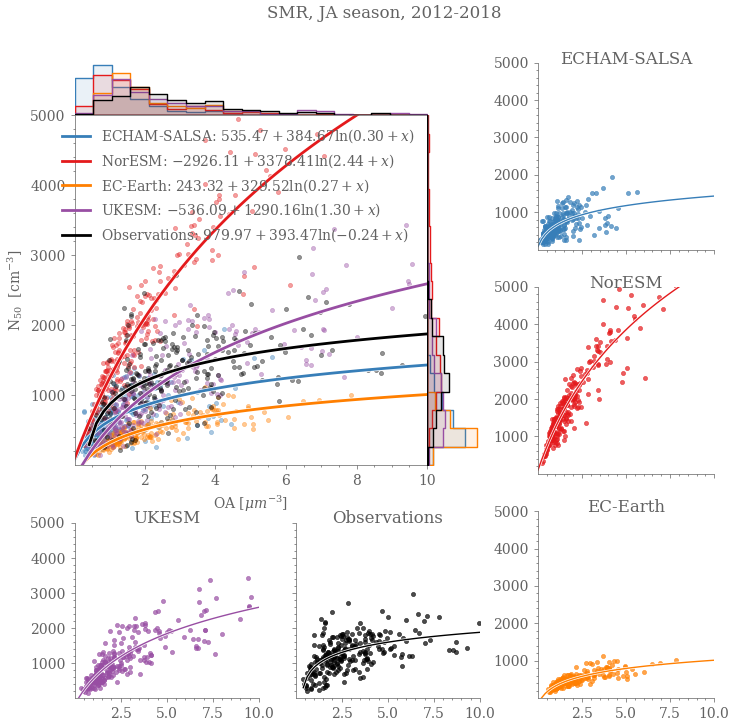

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [73]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{50}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,5000]

# OBS: 
v_x = 'OA'
v_y = 'N50'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    x = np.linspace(*xlims)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))
    
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )

    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/SMR/scat_all_years_echam_noresm_residual_ln_JA_OA_N50-SMR_ukesm.png


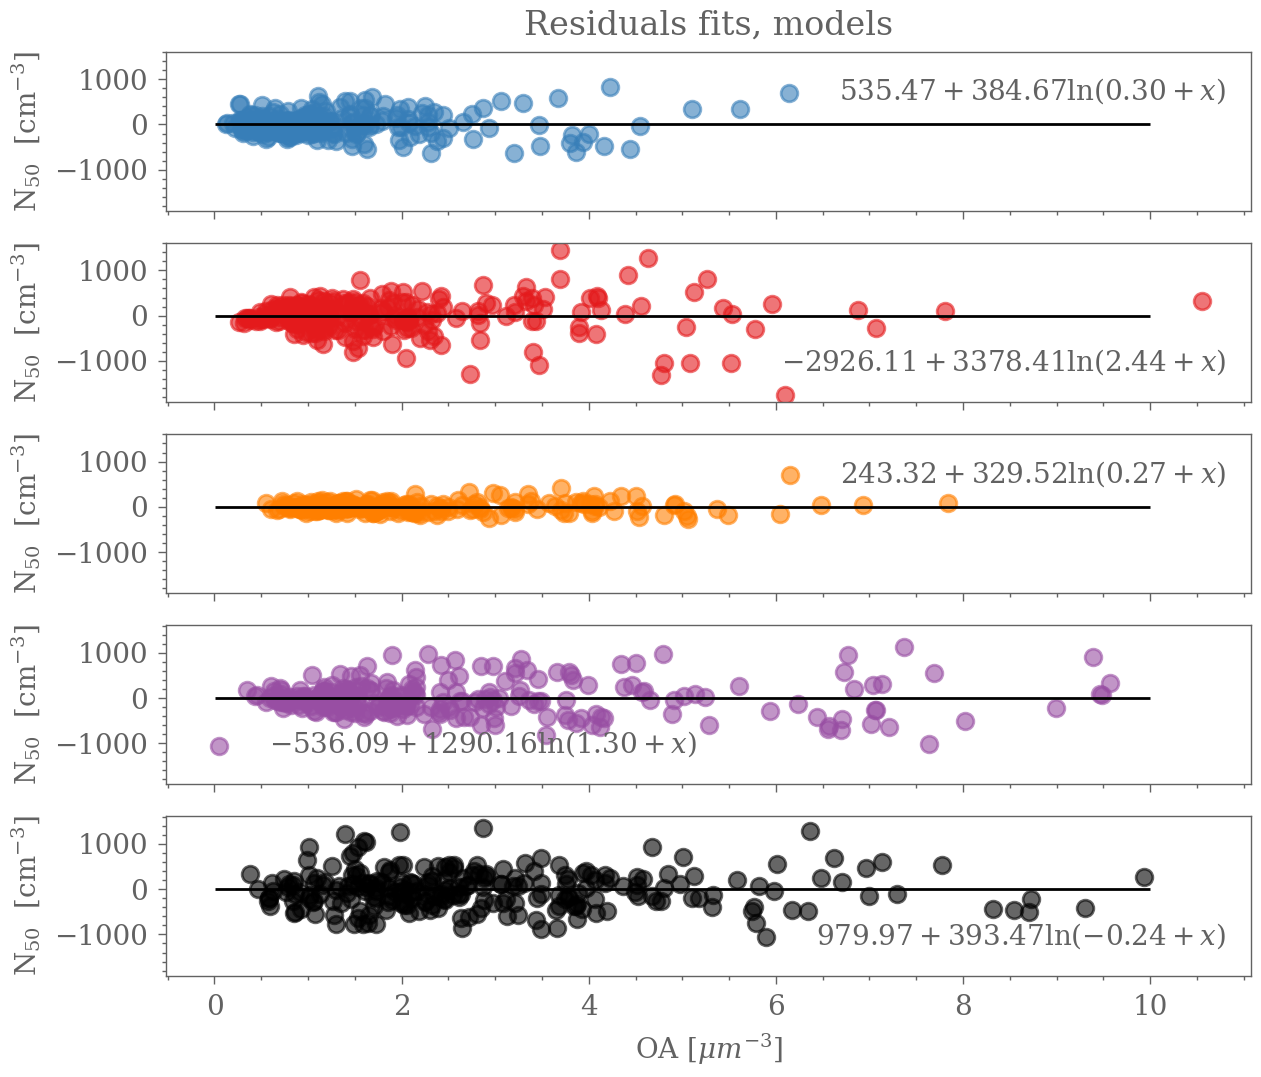

In [74]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{50}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

#ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N50'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_ln_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## N100

(0.0, 82.95)
(0.0, 82.95)
(0.0, 82.95)
(0.0, 82.95)
(0.0, 82.95)
ECHAM-SALSA
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

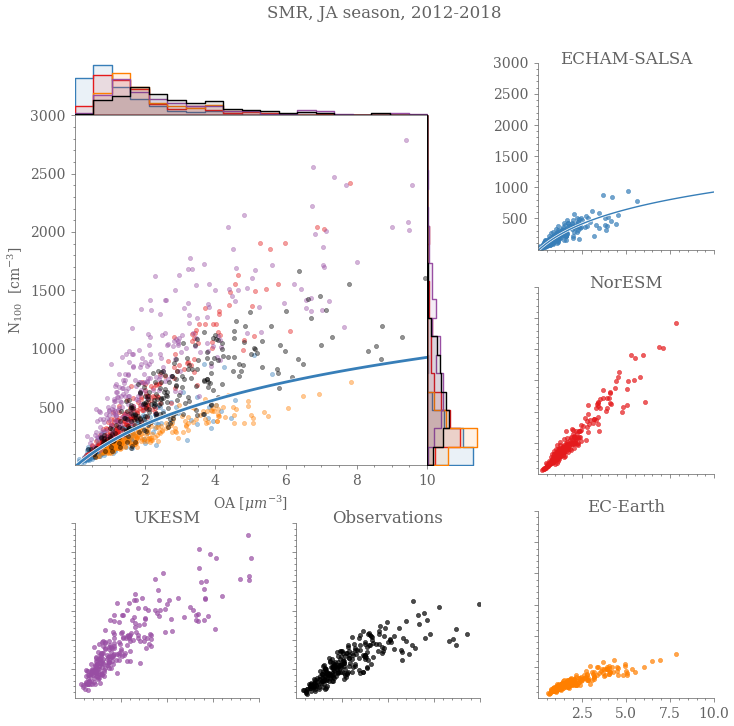

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [75]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{100}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,3000]

# OBS: 
v_x = 'OA'
v_y = 'N100'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    x = np.linspace(*xlims)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))
    
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )

    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

In [ ]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{100}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

#ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N100'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_ln_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## N200

In [ ]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim,1000)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

In [ ]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_linear_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## N200: ax

In [ ]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='ax', return_func=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim,1000)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

In [ ]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='ax', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_ax_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

In [ ]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_linear_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

In [ ]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_linear_{season}', v_x, v_y)
ax.legend(frameon=False)
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

In [ ]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

In [ ]:
plt.scatter(df_s[v_x].dropna(),out.y)
plt.scatter(df_s[v_x].dropna(),df_s[v_y].dropna(), marker='.')

In [ ]:
#plt.scatter(df_s[v_x].dropna(),out.y)

#plt.scatter(df_s[v_x].dropna(),func(df_s[v_x].dropna(),*popt))
#plt.scatter(df_s[v_x],df_s[v_y])
plt.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x].dropna(),*popt))
#plt.scatter(df_s[v_x].dropna(),df_s[v_y].dropna(), marker='.')